# Cruise Control: State-Space Methods for Controller Design

In this tutorial we will design a controller and observer for the cruise control system using the state-space model. 

## State-space equations

The equations of motion in state-space form are as follows: 

$$
[\dot{v}]=\left[\frac{-b}{m}\right][v]+\left[\frac{1}{m}\right][u]
$$

$$
y=[1][v]
$$

where:

```
(m)   vehicle mass            1000 kg
(b)   damping coefficient     50 N.s/m
(u)   nominal control force   500 N
(v)   vehicle velocity where y=v is the system output
```

## Design requirements


* Rise time < 5 s 
* Overshoot < 10 
* Steady-state error < 2 To see the original problem setup, see the [Cruise Control: System Modeling](CruiseControl_SystemModeling.ipynb) page. 

## Control design using pole placement

The schematic of a full state-feedback system is shown below. 
![statefeedback_cruise.png](figures/statefeedback_cruise.png)
 where 
* K = state-feedback gain matrix 
* u = r - K.x = r - K.v = control input

Recall from the [State-Space Tutorial](../Introduction/Introduction_ControlStateSpace.ipynb) page, we can use a "pole placement" technique to obtain the desired output. Poles of a closed-loop system can be found from the characteristic equation: the determinant of the `sI-(A-B*K)` matrix. If the poles of the system can be placed in the desired location by designing an appropriate control matrix (K), then the desired output can be obtained. In this tutorial, poles will be chosen first, then we will use MATLAB to find the corresponding control matrix (K).

Now, we need to determine where to place poles for our system. Since our `[sI-(A-B*K)]` matrix is 1x1, we have only one pole to place. Let the pole be at -1.5 (arbitrary). Just as in the State-Space Tutorial, the command `control.place` will be used to find the control matrix K.

In [1]:
import control
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Generate Larger more readable plots
sns.set(
    rc={
        "axes.labelsize": 8,
        "axes.titlesize": 8,
        "figure.figsize": (4 * 1.618, 4),
        "figure.dpi": 200,
    }
)

In [2]:
m = 1000
b = 50
t = np.arange(0, 10, 0.1)
u = 500 * np.ones(t.shape)

A = np.array([[-b / m]])
B = np.array([[1 / m]])
C = np.array([[1]])
D = np.array([[0]])

sys = control.StateSpace(A, B, C, D)

x0 = np.array([[0]])

p1 = -1.5

K = control.place(A, B, [p1])
K

matrix([[1450.]])

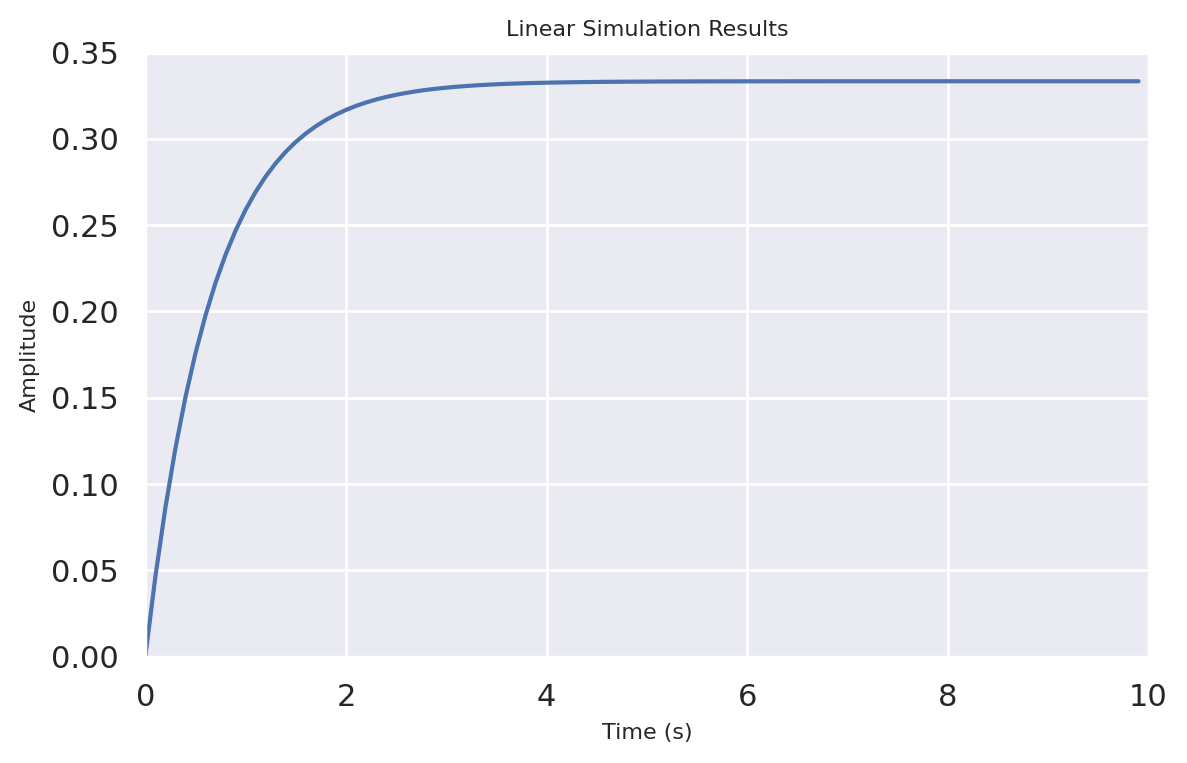

In [3]:
sys_cl = control.StateSpace(A - B * K, B, C, D)

T, yout, _ = control.forced_response(sys_cl, T=t, U=u, X0=x0)
plt.plot(T, yout)
plt.axis([0, 10, 0, 0.35])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Linear Simulation Results")
plt.grid("on")

As you can see, the rise time is satisfactory, but the steady-state error is too large. 

# Reference input

Once again from the [State-Space Tutorial](../Introduction/Introduction_ControlStateSpace.ipynb) page, a scaling factor called Nbar (the schematic is shown below) can be used to eliminate the steady-state error. We can use the `rscale` function to compute the scaling factor. The input is already multiplied by 500, and we want the steady-state speed to be 10 m/sec, so we need to account for these factors as well. 

![statefeedback_w_pre_cruise.png](figures/statefeedback_w_pre_cruise.png)


In [4]:
def rscale(sys, K):
    s = A.shape[0]
    Z = np.zeros((s + 1, 1))
    Z[-1] = 1
    # Concatenate each section
    N = (
        np.linalg.inv(
            np.block(
                [
                    [sys.A, sys.B],
                    [sys.C, sys.D],
                ]
            ),
        )
        * Z
    )
    Nx = N[0:-1]
    Nu = N[-1]
    return Nu + K * Nx

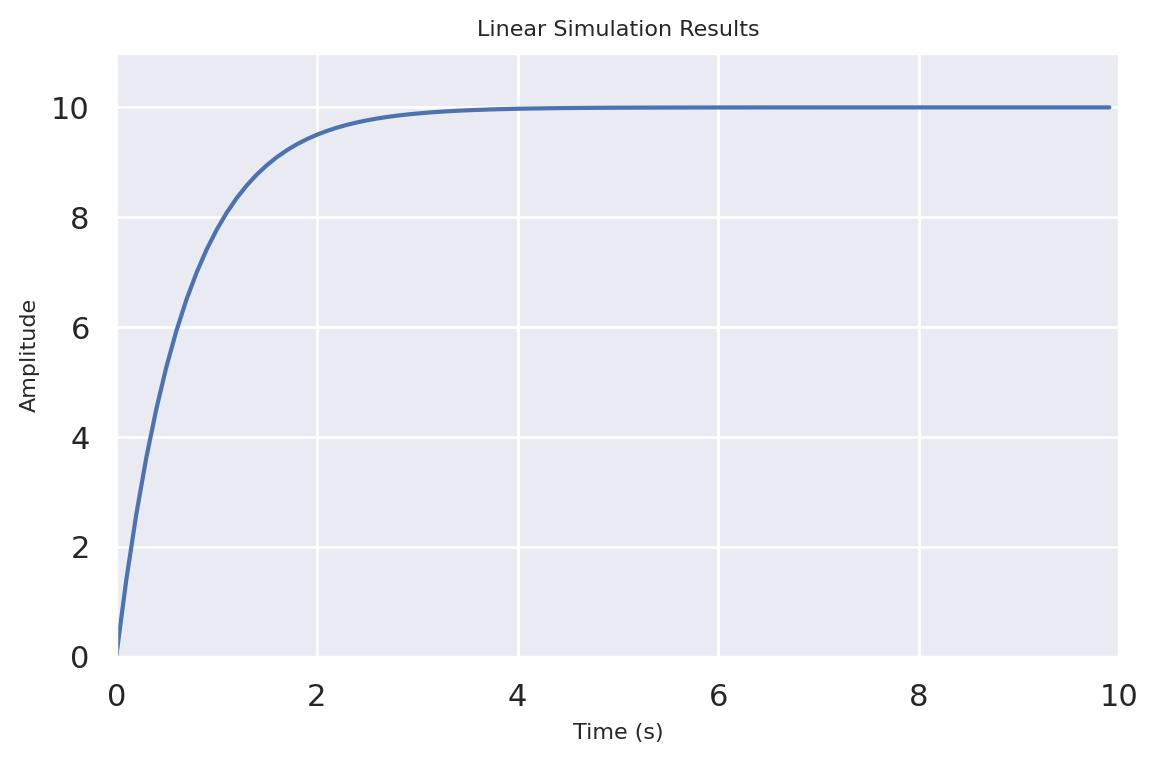

In [5]:
Nbar = rscale(sys, K) * 10 / 500
sys_cl = control.StateSpace(A - B * K, B * Nbar, C, D)

T, yout, _ = control.forced_response(sys_cl, T=t, U=u, X0=x0)
plt.plot(T, yout)
plt.axis([0, 10, 0, 11])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Linear Simulation Results")
plt.grid("on")

As you can see, the steady-state error has been eliminated. The rise time is less than 5 seconds and the overshoot is, in fact, zero. All the design requirements are satisfied. 